### Przydzielona karta graficzna:

In [0]:
!nvidia-smi

Thu Jun 20 09:49:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Import bibliotek

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
!pip install scikit-learn
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
import pandas as pd

from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(100)

### Import bibliotek do budowy CNN

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

!pip install livelossplot
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


### Wczytanie tensorów X i y 

In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [0]:
print(X.shape, y.shape)

### Zdefiniowanie parametrów augmentacji danych

In [0]:
def augment(img, steering_angle):
  
  ## flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  
  ## blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 2))
  img = blurer.augment_image(img)
  
  ## contrast
  contrast = iaa.GammaContrast((0.5,2.0))
  img = contrast.augment_image(img)
  
  ## channel shuffle
  sh = iaa.ChannelShuffle(p=0.4)
  img = sh.augment_image(img)
  
  #snow = iaa.Snowflakes(density=(0.03,0.075))
  #img = snow.augment_image(img)
  
  ## fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  
  # translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={"x":tx}, mode = "edge")
  steering_angle += tx*0.025
  
  img = translater.augment_image(img)
    
  return img, steering_angle
  

# wyświetlenie przykładowego obrazu przed i po zmianie  
plt.imshow(X[0])
print(y[0])
plt.show();
  
img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

### Podział tensorów X i y na zbiór treningowy i walidacyjny

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [0]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11412, 35, 80, 3) (11412,)
(2853, 35, 80, 3) (2853,)


### Augmentacja danych

In [0]:
Xgen=[]
ygen=[]


for i in range(X_train.shape[0]):
  img,angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

### Porównanie histogramów kąta sterowania przed i po augmentacji

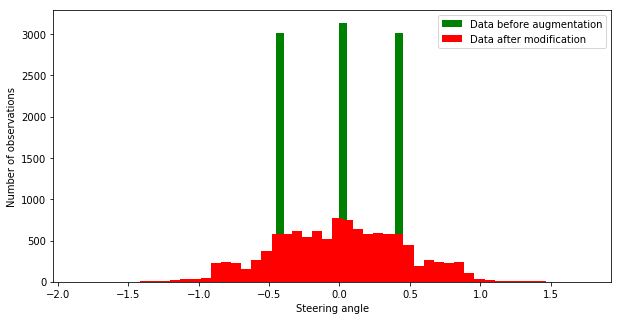

In [0]:
plt.figure(figsize=(10,5))
plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');
plt.xlabel('Steering angle');
plt.ylabel('Number of observations');
plt.legend(['Data before augmentation','Data after modification']);
plt.show()

### Budowa architektury CNN

In [0]:
# NVIDIA ORYGINALNA
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape = input_shape, 
             name='normalize'),
      
      Conv2D(24,(5,5), activation = 'relu',strides=(2,2)),
      Conv2D(36,(5,5), activation = 'relu',strides=(2,2)),         
      Conv2D(48,(3,3), activation = 'relu',strides=(1,1)),
      Conv2D(64,(3,3), activation = 'relu',strides=(1,1)),
      
      Flatten(),
      
      Dense(100, activation = 'elu'),
      Dense(50, activation = 'elu'),
      Dense(10, activation = 'elu'),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)


### Kompilacja modelu

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 35, 80, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 38, 24)        1824      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 6, 17, 36)         21636     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 4, 15, 48)         15600     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 13, 64)         27712     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               166500    
__________

### Trenowanie modelu

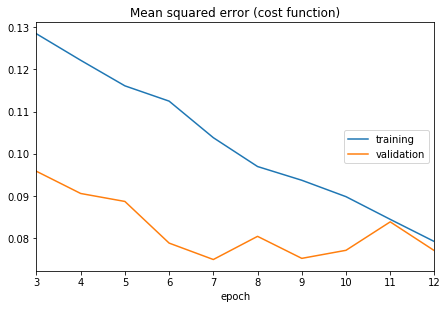

Mean squared error (cost function):
training   (min:    0.079, max:    0.219, cur:    0.079)
validation (min:    0.075, max:    0.106, cur:    0.077)


In [0]:
batch_size = 512
epochs =12
history = model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesCallback()],
         verbose=2)

### Predykcja kąta sterowania 

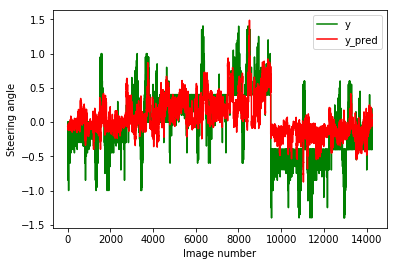

In [0]:
y_pred = model.predict(X)


# porównanie kąta sterowania y i y_pred
plt.figure()
plt.plot(y, 'g', y_pred,'r' )
plt.xlabel('Image number');
plt.ylabel('Steering angle');
plt.legend(['y','y_pred']);

plt.show();

### Zapis modelu do pliku

In [0]:
model.save('cnn_model_nvidia1_b512_e12_relu.h5')

### Własna modyfikacja modelu NVIDIA

In [0]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape = input_shape, 
             name='normalize'),
      
      Conv2D(24,(5,5), activation = 'elu'),
      MaxPooling2D(strides=(2,2)),
                  
      Conv2D(36,(5,5), activation = 'elu'),
      MaxPooling2D(strides=(2,2)),
                 
      Conv2D(48,(3,3), activation = 'elu'),
      MaxPooling2D(strides=(1,1)),
           
      Conv2D(64,(3,3), activation = 'elu'),
      MaxPooling2D(strides=(1,1)),
            
      Flatten(),
      
      Dense(100, activation = 'elu'),
      Dropout(rate=0.5),
      Dense(100, activation = 'elu'),
      Dropout(rate=0.25),
      Dense(50, activation = 'elu'),
      Dropout(rate=0.25),
      Dense(10, activation = 'elu'),
      Dense(1)
      
  ])
  return model
  model = myModel(X[0].shape)
  

### Kompilacja modelu

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 70, 80, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 38, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 17, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 15, 48)        15600     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 13, 64)        27712     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               915300    
__________

### Trenowanie modelu

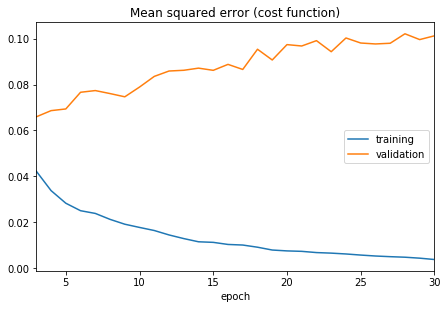

Mean squared error (cost function):
training   (min:    0.004, max:    0.114, cur:    0.004)
validation (min:    0.066, max:    0.102, cur:    0.101)


In [0]:
batch_size = 512
epochs =30

history = model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesCallback()],
         verbose=2)

### Predykcja y_pred

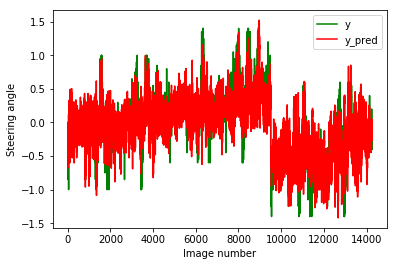

In [0]:
y_pred = model.predict(X)

plt.figure()
plt.plot(y,'g', y_pred,'r')
plt.xlabel('Image number');
plt.ylabel('Steering angle');
plt.legend(['y','y_pred']);

plt.show();

### Zapis modelu

In [0]:
model.save('cnn_model_nvidia1mod_b512_e30_relu.h5')